In [4]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


### **Getting the Dataset.**

In [5]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 98% 392M/401M [00:01<00:00, 228MB/s]
100% 401M/401M [00:01<00:00, 212MB/s]


In [6]:
!unzip /content/sports-balls-multiclass-image-classification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/cricket_ball/cricket_ball_182.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_183.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_185.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_186.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_187.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_189.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_19.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_190.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_191.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_192.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_195.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_196.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_199.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_200.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_

In [7]:
# Importing the Required Packages.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

import glob
import random
import os

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling

# For reproducibility.
seed=123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
# Directory path.
train_dir = "/content/train"

# Dictionary to store subdirectgory names and file counts.
data = {
    "Category": [],
    "Image Count": []
}

# Loop through each sub-directory.
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    # "/content/train/american_football"
    if os.path.isdir(sub_dir_path):
        # Count the number of files (images) in the subdirectory.
        num_files = [file for file in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, file))]
        data["Category"].append(sub_dir)
        data["Image Count"].append(num_files)

'''
Format of the ouput will be like this:
{
    'Category': [
        'golf_ball',
        'table_tennis_ball',
        'tennis_ball',
        'billiard_ball',
        'baseball',
        'football',
        'american_football',
        'shuttlecock',
        'volleyball',
        'basketball',
        'hockey_puck',
        'hockey_ball',
        'bowling_ball',
        'rugby_ball',
        'cricket_ball'
    ],

    'Image Count': [
        [
            'golf_ball_1252.jpg',
            'golf_ball_394.jpg',
            'golf_ball_1400.jpg',
            'golf_ball_1003.jpg',
            'golf_ball_1168.jpg',
            'golf_ball_1161.jpg',
            'golf_ball_1308.jpg',
            'golf_ball_1300.jpg',
            'golf_ball_869.jpg',
            'golf_ball_810.jpg',
            'golf_ball_813.jpg',
            'golf_ball_1134.jpg',
            'golf_ball_1382.jpg',
            'golf_ball_1080.jpg',
            'golf_ball_611.jpg',
            'golf_ball_481.jpg',
            'golf_ball_434.jpg',
            'golf_ball_401.jpg',
        ]
    ]
}
'''

,Category,Image Count
0,golf_ball,"[golf_ball_1252.jpg, golf_ball_394.jpg, golf_b..."
1,table_tennis_ball,"[table_tennis_ball_822.jpg, table_tennis_ball_..."
2,tennis_ball,"[tennis_818.jpg, tennis_57.jpg, tennis_451.jpg..."
3,billiard_ball,"[billiard_ball_1323.jpg, billiard_ball_715.jpg..."
4,baseball,"[baseball_725.jpg, baseball_220.jpg, baseball_..."


In [11]:
# Convert the data to a pandas DataFrame.
# data
df = pd.DataFrame(data)
df.head()

,Category,Image Count
0,golf_ball,"[golf_ball_1252.jpg, golf_ball_394.jpg, golf_b..."
1,table_tennis_ball,"[table_tennis_ball_822.jpg, table_tennis_ball_..."
2,tennis_ball,"[tennis_818.jpg, tennis_57.jpg, tennis_451.jpg..."
3,billiard_ball,"[billiard_ball_1323.jpg, billiard_ball_715.jpg..."
4,baseball,"[baseball_725.jpg, baseball_220.jpg, baseball_..."


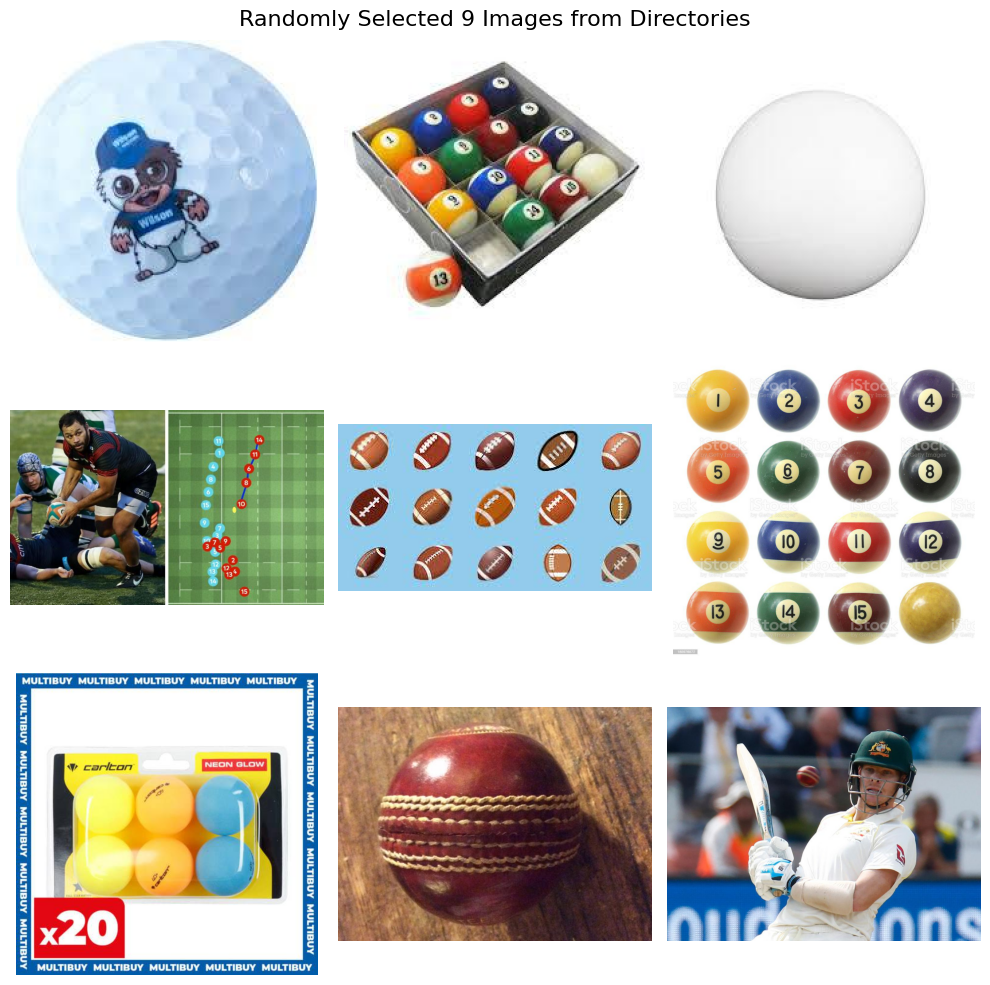

In [14]:
# Randomly Visualizing the some of the images.

# Get all subdirectories and files in the directories.
all_images = []
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        all_images.extend([os.path.join(sub_dir_path, f) for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])

# Randomly select 9 images.
random_images = random.sample(all_images, 9)

# Plotting the images in a 3x3 Grid.
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off") # Turn off the axis.

plt.suptitle("Randomly Selected 9 Images from Directories", fontsize=16)
plt.tight_layout()
plt.show()

## **Data Preparation.**

In [15]:
# setup directory and parameters.
image_size = (224, 224) # ResNet50 standard input size.
batch_size = 32

# Data Augmentation Layers (Applied during training phase only).
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # Random Horizontal Flip.
    layers.RandomRotation(0.1), # Random Rotation.
    layers.RandomZoom(0.1), # Random Zoom.
])

# Loading training datasets using `image_dataset_from_directory`.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred", # inferred means main directory contains sub-directories
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=123, # for reproducibility
    image_size=image_size,
    batch_size=batch_size
)

# Loading validation datasets using `image_dataset_from_directory`.
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

# Now, Implements the data augmentation only to the training data.
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [16]:
# Implementings the some callbacks.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [29]:
# Include Learning Reate Scheduler.
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3
)

In [30]:
# Add Early Stopping.
early_stopping= tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

## **Building an Models.**

Residual Block Explained Links: https://youtu.be/Q1JCrG1bJ-A

In [31]:
# Residual Blocks are skip-connections that learn residual functions with reference to the layers inputs, instead of learning unreferenced functions.
# skip-connections: Adding the inputs to the output of the convolution block.

def residual_block(x, filters, kernel_size=3, stride=1):
    # storing the original input.
    shortcut = x

    # First 1x1 Convolution to reduce dimensions.
    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x) # Batch Normaliazation normalizes input of the ecah layer by scaling & shifting so that activations function have stable distribution across training.
    x = layers.Activation("relu")(x)

    # Second 3x3 Convolution.
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Third 1x1 Convolution to restore dimensions.
    x = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection (adjust dimensions if necessary).
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut before the relu activation.
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    return x

In [32]:
def ResNet50(input_shape=(224, 224, 3), num_classes=15):
    # storing the inputs.
    inputs = tf.keras.Input(shape=input_shape)

    # rescaling the input.
    # x = layers.rescaling(1/255.)

    # Initial Convolution and MaxPooling.
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)


    # Residual Blocks (BottleNeck Architecture)

    # Repeating this 3 times.
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Repeating again 4 times with filters=128. and stride=2.
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    # Repeating again 6 times with filters=256, and stride=2.
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    # Repeating the residual block again 3 times with filters=512, and stride=2.
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    # Global Average Pooling and Output.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x) # softmax activation functions is used because it transforms the raw outputs of the neural network into a vector of probabilities, essentially a probability distribution over the input classes

    model = models.Model(inputs, x)
    return model

In [33]:
# Build the Model.
model = ResNet50(input_shape=(224, 224, 3))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_133 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_132   │ (None, 112, 112, 64)   │            256 │ conv2d_133[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_98             │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 64)     │              0 │ activation_98[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_134 (Conv2D)       │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_133   │ (None, 56, 56, 64)     │            256 │ conv2d_134[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_99             │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_135 (Conv2D)       │ (None, 56, 56, 64)     │         36,928 │ activation_99[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_134   │ (None, 56, 56, 64)     │            256 │ conv2d_135[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_100            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_136 (Conv2D)       │ (None, 56, 56, 256)    │         16,640 │ activation_100[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_137 (Conv2D)       │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_135   │ (None, 56, 56, 256)    │          1,024 │ conv2d_136[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_136   │ (None, 56, 56, 256)    │          1,024 │ conv2d_137[0][0]       │
│ (BatchNormalization) 

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 23,565,327 (89.89 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [34]:
# Compile the model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [36]:
# Training the models.
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 187s 695ms/step - accuracy: 0.1322 - loss: 3.3595 - val_accuracy: 0.1229 - val_loss: 4.9453 - learning_rate: 0.0010
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 101s 547ms/step - accuracy: 0.1831 - loss: 2.6309 - val_accuracy: 0.0471 - val_loss: 43.2266 - learning_rate: 0.0010
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 540ms/step - accuracy: 0.2265 - loss: 2.4305 - val_accuracy: 0.0976 - val_loss: 31.9027 - learning_rate: 0.0010
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 145s 557ms/step - accuracy: 0.2740 - loss: 2.3247 - val_accuracy: 0.2116 - val_loss: 3.4466 - learning_rate: 0.0010
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 137s 528ms/step - accuracy: 0.3052 - loss: 2.1848 - val_accuracy: 0.3577 - val_loss: 2.0518 - learning_rate: 0.0010
